In [8]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy,os,glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

In [9]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

In [10]:
mbathy=mesh.variables['mbathy'][0,700,210]
gdept=mesh.variables['gdept'][0,:mbathy,700,210]
gdepw=mesh.variables['gdepw'][0,:mbathy,700,210]
e3t=mesh.variables['e3t'][0,:mbathy,700,210]
e3w=mesh.variables['e3w'][0,:mbathy+1,700,210]

In [11]:
ice=nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice/noaa_icemod_y1958m09.nc')
ice=ice.variables['ileadfra'][0,700,210]
print ice

xd=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc')
xd=xd.variables['Th_diss'][0,:mbathy,700,210]

xp=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc')
xp=xp.variables['Th_part'][0,:mbathy,700,210]

0.797721


In [12]:
import pylab

I = np.zeros(gdept.shape) # Ice signal
S = np.zeros(gdept.shape)
k_ad = np.zeros(gdept.shape)

Q = 0.0267     #dpm/m^3
k_de = 0.8     #desorption constants

In [13]:
# time info
dt = 1./365/24/3600*1080
t = 0.0
tmax = 1  #yr

# initialize the data 
xd_=np.copy(xd)
xp_=np.copy(xp)


anew=np.zeros(xd.shape)
bnew=np.zeros(xd.shape)
cnew=np.zeros(xd.shape)

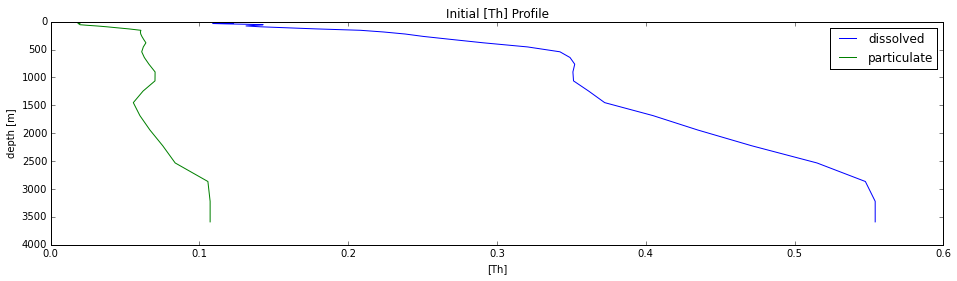

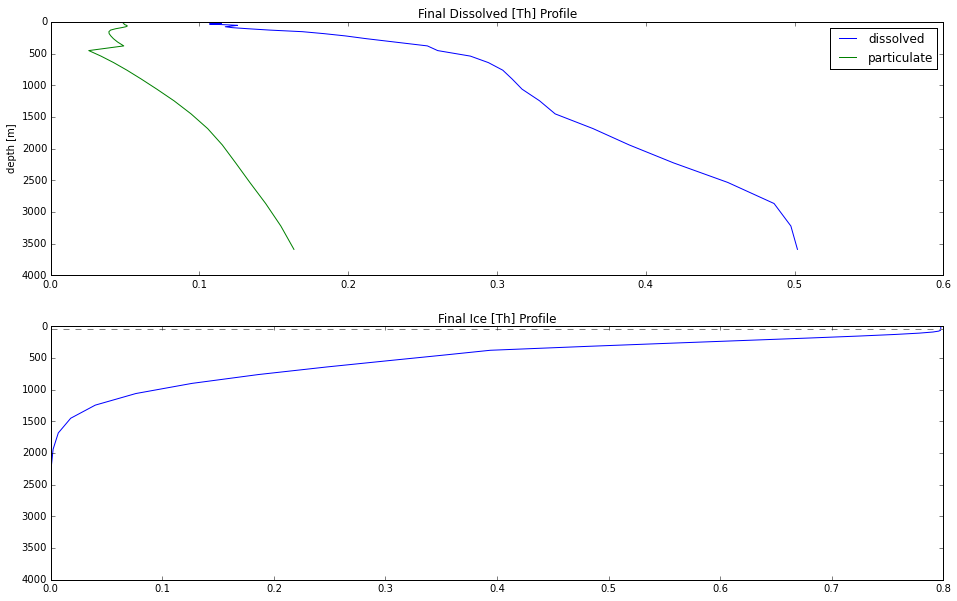

In [14]:
while (t < tmax):               # loop through all dt on [0, tmax]
    I[:16]=ice                   # ice/sinking rate/adsorption constants
    S[:30] = -689.3*I[:30]+1323*0.5   
    S[30:] = -689.3*I[30:]+1323       
    k_ad[:] = 0.23*I[:]+0.37
    
    i=0                         # the surface BC.
    anew[i] = xd_[i+1]           
    bnew[i] = xp_[i+1] 
    cnew[i] = I[i+1]        
    
    i += 1
    while (i <= mbathy-1):     # loop through all depths
        
        # forward difference
        anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i] = xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3w[i+1] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        cnew[i] = I[i] + (I[i-1]-I[i])*S[i]/e3w[i+1] * dt
        
        i += 1

    # store the updated solution
    xd_[:] = anew[:]
    xp_[:] = bnew[:]
    I[:]   = cnew[:]

    t += dt


# initial dissolved and particulate
pylab.figure(1, figsize = (16, 4))  
pylab.plot(xd, gdept)
pylab.plot(xp, gdept)

# final dissolved and particulate
pylab.figure(2, figsize = (16, 10))
pylab.subplot(211)
pylab.plot(xd_, gdept)
pylab.plot(xp_, gdept)
pylab.subplot(212)
pylab.plot(I, gdept)
pylab.axhline(y=gdept[16],color='grey',ls='--')
    

# label and scale plots
pylab.figure(2, figsize = (16, 8))
pylab.subplot(211)
pylab.ylabel('depth [m]')
pylab.title('Final Dissolved [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.gca().invert_yaxis()
pylab.xlim([0,0.6])
pylab.subplot(212)
pylab.title('Final Ice [Th] Profile')
pylab.gca().invert_yaxis()


pylab.figure(1, figsize = (16, 4))
pylab.gca().invert_yaxis()
pylab.title('Initial [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.ylabel('depth [m]')
pylab.xlabel('[Th]')

ps. The initial ice condition is zero for all depths.

In [15]:
I

array([  7.97720790e-01,   7.97720790e-01,   7.97720790e-01,
         7.97720790e-01,   7.97720790e-01,   7.97720790e-01,
         7.97720790e-01,   7.97720790e-01,   7.97720790e-01,
         7.97720790e-01,   7.97720790e-01,   7.97720790e-01,
         7.97720790e-01,   7.97720790e-01,   7.97720790e-01,
         7.97720790e-01,   7.97720773e-01,   7.97719662e-01,
         7.97694477e-01,   7.97429093e-01,   7.95917313e-01,
         7.90705831e-01,   7.78528503e-01,   7.56885208e-01,
         7.24575438e-01,   6.81120086e-01,   6.26212544e-01,
         5.59658503e-01,   4.81763677e-01,   3.94110719e-01,
         3.53634816e-01,   3.04467476e-01,   2.47473898e-01,
         1.86160443e-01,   1.26773005e-01,   7.64705006e-02,
         4.01168871e-02,   1.80819256e-02,   6.96863970e-03,
         2.30030964e-03,   6.54513435e-04,   1.61975532e-04,
         3.52200755e-05,   6.91844767e-06,   1.26685173e-06])

In [16]:
xp_

array([ 0.0485114 ,  0.04851205,  0.04851274,  0.04851329,  0.04851616,
        0.04851929,  0.04853037,  0.04855124,  0.04858436,  0.04863342,
        0.04870282,  0.0488136 ,  0.0489606 ,  0.0491732 ,  0.04934579,
        0.0494032 ,  0.04961472,  0.05016077,  0.0510914 ,  0.05163428,
        0.05066859,  0.04775858,  0.04372074,  0.0403673 ,  0.03923346,
        0.03940081,  0.04051551,  0.04226945,  0.04502554,  0.04923252,
        0.02571288,  0.03390966,  0.04243444,  0.05137749,  0.06095798,
        0.07146829,  0.08296128,  0.09445558,  0.10561654,  0.11545011,
        0.1244211 ,  0.13395083,  0.14458175,  0.15478903,  0.16358945], dtype=float32)

In [17]:
S

array([  111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63105952,   111.63105952,   111.63105952,   111.63105952,
         111.63107096,   111.63183741,   111.64920371,   111.83218428,
         112.87447501,   116.46729565,   124.86201955,   139.78186577,
         162.0542392 ,   192.00935049,   229.85854087,   275.73572069,
         329.43006535,   389.8504343 ,  1079.25136485,  1113.14318624,
        1152.42919698,  1194.69205281,  1235.62619154,  1270.2971353 ,
        1295.3528014 ,  1310.53906641,  1318.1978588 ,  1321.41491062,
        1322.5490105 ,  1322.88839652,  1322.97573394,  1322.99523351,
        1322.99912724])